## **<center> An Analysis On Monster Hunter: Rise Speedruns </center>**
## <center>Sean Mohs</center>
***

<center><img src="mhrise.jpg" width="800" height="400"></center>

## <center>Introduction</center>
<a href="https://www.monsterhunter.com/rise/us/" target="Monster Hunter: Rise">Monster Hunter: Rise</a> (MHR) is an Action RPG game made by Capcom, released on Nintendo Switch in March of 2021, and January of 2022 for PC, and is personally one of my favorite games. MHR is the sixth installment of the Monster Hunter video game series, and a follow up to the widely popular Monster Hunter: World. As of August 2022, MHR and it's DLC have sold a total of 15 million units worldwide. The main objective of the game, as is evident it's name, is to hunt monsters. 

There are a total of 67 <a href="https://monsterhunterrise.wiki.fextralife.com/Large+Monsters" target="monsters">monsters</a> in the game and 14 different <a href="https://monsterhunterrise.wiki.fextralife.com/Weapons" target="weapon">weapon</a> types to take them down with. The gameplay of MHR is broken into instances called **quests**, also known as hunts, where 1 to 4 players fight 1 to 4 monsters in a quest. A quest is considered **complete** when the **target monster(s) of the quest are dead**, upon which the game take will note of how long it took to **complete the quest**. 

A focal point of each quest on top of actually killing the monster(s) and not failing the quest (dying 3 times or taking too long) is to minimize  **quest completion time**; that is, to be as efficient as possible in killing all target monsters. My interest and goal in this tutorial is to find out and analyze the **factors impacting quest completion time** and uncovering what advantages or strategies a player can take hunt the monster(s) as quickly as possible. An attempt at completing a quest as quickly as possible is known as a 'speedrun'.

In searching for relevant and ample data on MHR speedruns, I found the site <a href="https://www.mhrspeedrun.com/en/cms/quest/" target="mhrspeedrun.com">mhrspeedrun.com</a>, which has data on thousands of quest speedruns. I then navigated to <a href="https://www.mhrspeedrun.com/en/cms/submit_log/all/all/all/?page=1" target="this page">this page</a>, which contains over 8000 quest data entries over 90 pages, each of which list various pieces of information about the quest speedrun submission. Because I want to determine what factors correspond to the length of quest completion times, I am focusing on what variables I believe can have a significant impact. Thus, the variables I will be analyzing are: **Quest Difficulty**, **Quest Completion Time**, **Weapon Type**, **Rule**, and **Platform**. I will be going into more detail on what these mean as I conduct my exploratory data analysis. It should be noted that this dataset only contains entries from single players, meaning the quests are all conducted by one player instead of a team; this will keep quest completion time consistent in that regard. As a side note: if you are viewing this in dark mode or a dark themed browser, the code blocks may appear white and difficult to read. Please switch to a light mode version, and the code should be easier to read. Thank you.

***
## <center>Data Collection/Curating + Parsing</center>
Our first task is actually retrieving this data, parsing out the information of interest, and formatting it in an organized manner, making data analysis easier. Notably, parsing was done with BeautifulSoup, and analysis was done in part with Seaborn.

In [37]:
# imports for gathering, parsing, and analyzing data
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

To scrape this data, I iterated through all 90 pages (starting from: https://www.mhrspeedrun.com/en/cms/submit_log/all/all/all/?page=1) and collected relevant data through BeautifulSoup, making use of the findNext() function to locate these datapoints. I also used some regex to extract data into the form I wanted, among other wrangling methods seen in the code below. I collected all relevant data (Quest Difficulty, Quest Completion Time, Weapon Type, Rule, and Platform) into lists to be put into a DataFrame.

In [38]:
# all numerical quest difficulties
diff_types_num = ['1','2','3','4','5','6','7','8']
# expert and advanced quests correspond to 7 and 8 star difficulties, respectively
expert = '7'
advanced = '8'
# star character preceding difficulty 
star = '★'
# lists to be populated and inserted into dataframe
quest_list = []
runner_list = []
time_list = []
weapon_list = []
rule_list = []
platform_list = []

# iterate through all 90 pages, querying the ith page each iteration; accessing
# each page by changing the 'page=' at the end of the request url to current iteration
for i in range(1, 91):
    res = requests.get(f'https://www.mhrspeedrun.com/en/cms/submit_log/all/all/all/?page={i}')
    soup = BeautifulSoup(res.text, 'html.parser')
    
    # locating the table among the html response data
    table = soup.find('table')
    
    # Need to find point of initial entry on current page first using findNext()
    # on the table tag. After the first entry is parsed, future entries on the 
    # current page are able to be accessed via findNext() from previous entry,
    # without having to use findNext() on table and indexing until reach next entry
    # to analyze; this is why the initial parse is outside the while loop below.
    
    # finding quest name data
    hunt = table.findNext(class_ = 'text-secondary text-nowrap')
    # extracting quest difficulty by locating the ★ preceding difficulty
    for i, v in enumerate(hunt.text):
        if v == star:
            # 'Expert' quest = ★7
            if hunt.text[i+1] == 'E':
                difficulty = expert
            # 'Advanced' quest = ★8
            elif hunt.text[i+1] == 'A':
                difficulty = advanced
            # Numerical quest difficulty
            elif hunt.text[i+1] in diff_types_num:
                difficulty = hunt.text[i+1]
            else:
                difficulty = 0
    quest_list.append(int(difficulty))
    
    # finding player username, storing for determining 
    # accuracy of data collection
    runner = hunt.findNext('td')
    runner_list.append(runner.text)
    
    # finding quest completion time, parsing and reformatting
    # it into a float value representing minutes instead of
    # minutes'seconds"milliseconds
    time = runner.findNext('td')
    minutes = time.text.split("'")[0]
    seconds = time.text.split('"')[0].split("'")[1]
    milliseconds = time.text.split('"')[1]
    time_float_val = int(minutes) + (int(seconds)/60) + (int(milliseconds)/60000)
    time_list.append(float(time_float_val))
    
    # finding weapon type. weapon is displayed as an image
    # so need to parse out the actual name of the weapon from
    # the html. (also finding rule)
    weapon_type = time.findNext('td')
    rule = weapon_type.findNext('td')
    weapon_type = re.search('/.+.png', str(weapon_type))
    w_extraction = str(weapon_type.group())
    to_remove = re.search('/.+weapon_icon/', str(weapon_type))
    to_remove = str(to_remove.group())
    true_weapon_type = w_extraction.replace(str(to_remove),'')
    weapon_list.append(true_weapon_type.replace('.png',''))
    rule_list.append(rule.text)
    
    # finding platform
    platform = rule.findNext('td')
    platform_list.append(platform.text)
    
    # finding all other entries, and extracting data in the same manner as
    # the first. See comment block just after the request.
    while True:
        hunt = hunt.findNext(class_ = 'text-secondary text-nowrap')
        if hunt == None:
            break
        for i, v in enumerate(hunt.text):
            if v == star:
                if hunt.text[i+1] == 'E':
                    difficulty = expert
                elif hunt.text[i+1] == 'A':
                    difficulty = advanced
                elif hunt.text[i+1] in diff_types_num:
                    difficulty = hunt.text[i+1]
                else:
                    difficulty = 0
        quest_list.append(int(difficulty))
        runner = hunt.findNext('td')
        runner_list.append(runner.text)
        time = runner.findNext('td')
        minutes = time.text.split("'")[0]
        seconds = time.text.split('"')[0].split("'")[1]
        milliseconds = time.text.split('"')[1]
        time_float_val = int(minutes) + (int(seconds)/60) + (int(milliseconds)/60000)
        time_list.append(float(time_float_val))
        weapon_type = time.findNext('td')
        rule = weapon_type.findNext('td')
        weapon_type = re.search('/.+.png', str(weapon_type))
        w_extraction = str(weapon_type.group())
        to_remove = re.search('/.+weapon_icon/', str(weapon_type))
        to_remove = str(to_remove.group())
        true_weapon_type = w_extraction.replace(str(to_remove),'')
        weapon_list.append(true_weapon_type.replace('.png',''))
        rule_list.append(rule.text)
        platform = rule.findNext('td')
        platform_list.append(platform.text)

***
## <center>Data Management/Representation</center>
Now that the data has been collected and parsed, lets insert it into a DataFrame and inspect the results.

In [39]:
# inserting all 90 pages worth of data together in a single dataframe
headers = ['Quest', 'Runner', 'Time', 'Weapon', 'Rule', 'Platform']
master_list = []
master_list.append(quest_list)
master_list.append(runner_list)
master_list.append(time_list)
master_list.append(weapon_list)
master_list.append(rule_list)
master_list.append(platform_list)
total_hunt_df = pd.DataFrame()

for i in range(len(headers)):
    total_hunt_df[headers[i]] = master_list[i]

total_hunt_df.sample(5)

,Quest,Runner,Time,Weapon,Rule,Platform
6784,5,TKAZero,2.100733,charge-blade,TA,Switch
5005,7,登空居空回旋空,4.968250,insect-glaive,TA,Switch
4377,7,如月ジョー,4.817350,sword-and-shield,FR,Switch
7568,7,Po chi,3.517650,insect-glaive,FR,Switch
7120,7,ひろまるのTA専門 ch【ぼうずのちょうせん】,2.751050,light-bowgun,FR,Switch


Looks good! In using the site's search bar to find these 5 entries, we can compare and confirm that our collection process was successful. 

Now would be a good time to give a little background on the details of these datapoints.
**Quest** lists the star difficulty ratings of the entries. The difficulty system ranges from 1 star to 8 stars, increasing in difficulty as the star count increases. **Runner** lists the usernames of the player who completed the quest. **Time** lists the minutes it took to complete the quest. **Weapon** lists the type of weapon used in by the player. There are 14 weapon types: Great Sword, Sword and Shield, Dual Blades, Long Sword, Hammer, Hunting Horn, Lance, Gunlance, Switch Axe, Charge Blade, Insect Glaive, Bow, Light Bowgun, and Heavy Bowgun. **Rule** refers to the way in which the run was conducted. There are two types: FR, which stands for FreeStyle, has no limitations (other than cheating, of course) and TA, which stands for time attempt, the limitations and rules of which you can read <a href="https://www.mhrspeedrun.com/en/sbwiki/about/submit/" target="here">here</a>. Lastly, **Platform** refers to the device used to play the game on. as of December 2022, MHR is available only on the Nintendo Switch and PC.

***
## <center>Exploratory Data Analysis</center>
### <center>Quest Difficulty</center>
<center><img src="tigrex.jpg" width="800" height="400"></center>
<center>Hunters fighting a monster called the 'Tigrex', found in 7 star quests</center>

The first aspect we will be looking into is **quest difficulty rating** and how it affects quest completion time. Of course, it is reasonable to assume that the harder the quest, the longer it will take complete, as monster HP (amount of health a monster has) typically scales with difficulty rating. It might not be so straightforward, though, as other variables are at play in any given quest other than the monster's HP. For example, quests can take place in different maps with different environments, impacting a player's ability to actually get to the monster, other monsters on the map can interfere, or a variety of other variables might affect completion time. We will have the null hypothesis be that quest difficulty does not affect quest completion time / there is no correlation between quest difficulty and quest completion time. Let's first see quest completion time vs quest difficulty as a violin plot to examine their distributions, then as a bar plot to more clearly compare the averages.

Text(0.5, 0, 'Quest ★ Difficulty')

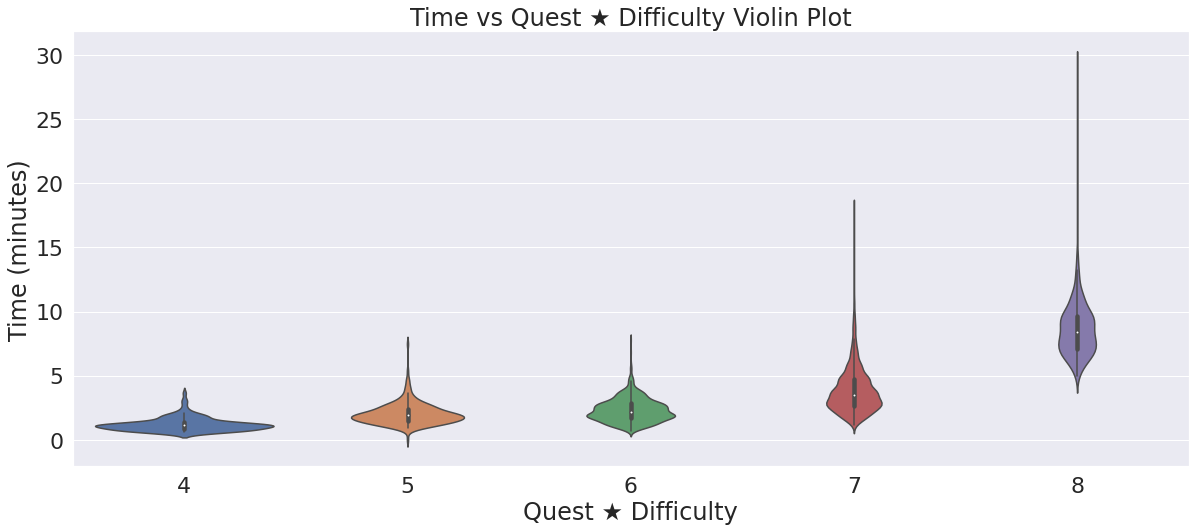

In [40]:
# plotting time vs quest difficulty on violin plot
plotdata = total_hunt_df
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(20,8))
ax = sns.violinplot(x='Quest',y='Time', data=plotdata)
ax.set_title('Time vs Quest ★ Difficulty Violin Plot')
ax.set_ylabel('Time (minutes)')
ax.set_xlabel('Quest ★ Difficulty')

Looking at the Time vs Quest ★ Difficulty violin plot, we can see that the **average time it takes
to complete a quest does increase with difficulty**, which is to be expected. It is also apparent that the minimum quest difficulty in this dataset is 4 stars. Each difficulty has a somewhat normal distribution, with most average completion times being about the mean of the subset. 4 stars has a high mode of completion times around its average, as seen through its wide center. 5's distribution is more spread out, and has the smoothest normal distribution of the bunch. 6 stars has a slightly more even distribution than 4 and 5. 7 stars is notably more stretched out, meaning completion times for 7 stars vary more than completion times for 4 through 6. 8 star quests even more so, with the highest variance of completion times out of them all. There are some outlier points, especially for 7 and 8 star quests. I believe this is because people who enter their times into a speedrun site like the one I am pulling from will usually only enter good/low completion times. Since most entries have a relatively low completion time compared to the average non-speedrun quest, entries with high/slow completion times will stand out much more in this collection of speedrun attempts.  Now that we have analyzed the distributions, let's get a better look at how the averages compare via barplot to have a better understanding of the relationship between completion time and quest difficulty.

Text(0.5, 0, 'Quest ★ Difficulty')

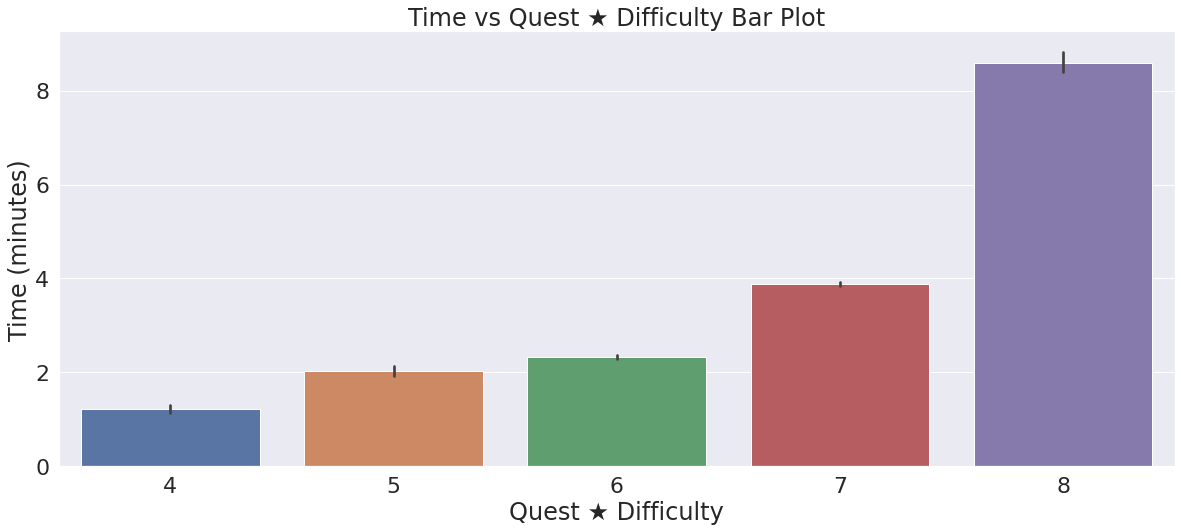

In [41]:
# plotting via barplot
plotdata = total_hunt_df
sns.set(font_scale = 2)
fig2, ax2 = plt.subplots(figsize=(20,8))
ax2 = sns.barplot(x='Quest',y='Time', data=plotdata)
ax2.set_title('Time vs Quest ★ Difficulty Bar Plot')
ax2.set_ylabel('Time (minutes)')
ax2.set_xlabel('Quest ★ Difficulty')

In analyzing the completion time vs difficulty barplot, the minimum difficulty of 4 stars sees the minimum average time of about 1.1 minutes. At 5 stars the average time is about 2 minutes and 6 is not far behind it with just over 2 minutes. 7 stars has a considerably higher average time of around 3.9 minutes. Most notably, though, 8 stars has a significantly higher average completion time than any other difficulty at about 8.2 minutes. This clear increase in average completion time as the quest difficulty increases **rejects the null hypothesis**. In fact, this trend seems to be **exponential** in nature, meaning that monsters get exponentially more difficult to kill as they are unlocked through harder, higher rated difficulty quests. My thoughts on why this is will come later in the tutorial.

### <center>Weapon Type</center>
<center><img src="longsword.png" width="800" height="400"></center>
<center>Player equipped with a Longsword</center>

The relationship between quest difficulty and completion time was not so outside of expectations, but now we will analyze a much more ambiguous relationship: **weapon type vs quest completion time**. As mentioned before, there are 14 weapon types, each of which gives the player a different way in which to fight monsters, with unique mechanics and modes of dealing damage. One would think that Capcom tries their best to balance each weapon, so as to not limit the player to choosing out of a specific few by necessity. In a perfect world, fourteen completely balanced weapons will result in our entries having about the same average quest completion times for each weapon type. The null hypothesis for this is: weapon type does not affect quest completion time / there is no correlation between weapon type and quest completion time.  Let's do the same visualization method as previous - first analyze via violin plots then via barplot.

Text(0.5, 0, 'Weapon Type')

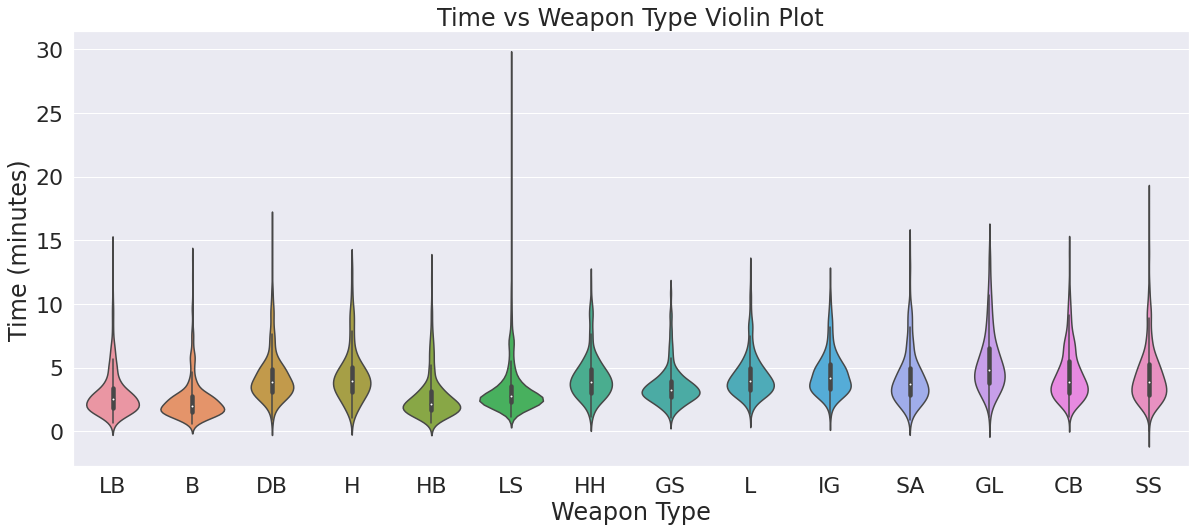

In [42]:
plotdata_w_vs_t = total_hunt_df
# listing all weapon types and their shorthand counterparts for ease of
# interpretation in the plot. Weapon names and intials share indicies in their
# respective lists
weapon_types = ['great-sword','sword-and-shield','dual-blades','long-sword',\
               'hammer', 'hunting-horn','lance','gunlance','switch-axe',\
               'charge-blade','insect-glaive','bow','light-bowgun', 'heavy-bowgun']
weapon_initials = ['GS','SS','DB','LS','H','HH','L','GL','SA','CB','IG','B','LB','HB']

# changing full weapon names to shorthand
initials_list = []
for idx, weapon in enumerate(plotdata_w_vs_t['Weapon']):
    for idx2, w_type in enumerate(weapon_types):
        if weapon == w_type:
            initials_list.append(weapon_initials[idx2])    
plotdata_w_vs_t['Weapon'] = initials_list

# plotting via violin plot
sns.set(font_scale = 2)
fig3, ax3 = plt.subplots(figsize=(20,8))
ax3 = sns.violinplot(x='Weapon',y='Time', data=plotdata_w_vs_t)
ax3.set_title('Time vs Weapon Type Violin Plot')
ax3.set_ylabel('Time (minutes)')
ax3.set_xlabel('Weapon Type')

The full names of the weapons have been replaced by their initials for clarity; GS = Greatsword, SS = Sword and Shield, DB = Dual Blades, LS = Longsword, H = Hammer, HH = Hunting Horn, L = Lance, GL = Gunlance, SA = Switch Axe, CB = Charge Blade, IG = Insect Glaive, LB = Light Bowgun, HB = Heavy Bowgun. From this violin plot, we can see that each weapon has a somewhat normal distribution. Gunlance and Sword and Shield have a significantly longer distribution than the rest, meaning their completion times varied more than the rest. It is hard to differentiate the averages with so many weapon types, so let's convert this into a bar plot. As a side note: it is also evident that the outlier(s) we saw in time vs difficulty plot are Longsword entries, for whatever that's worth.

Text(0.5, 0, 'Weapon Type')

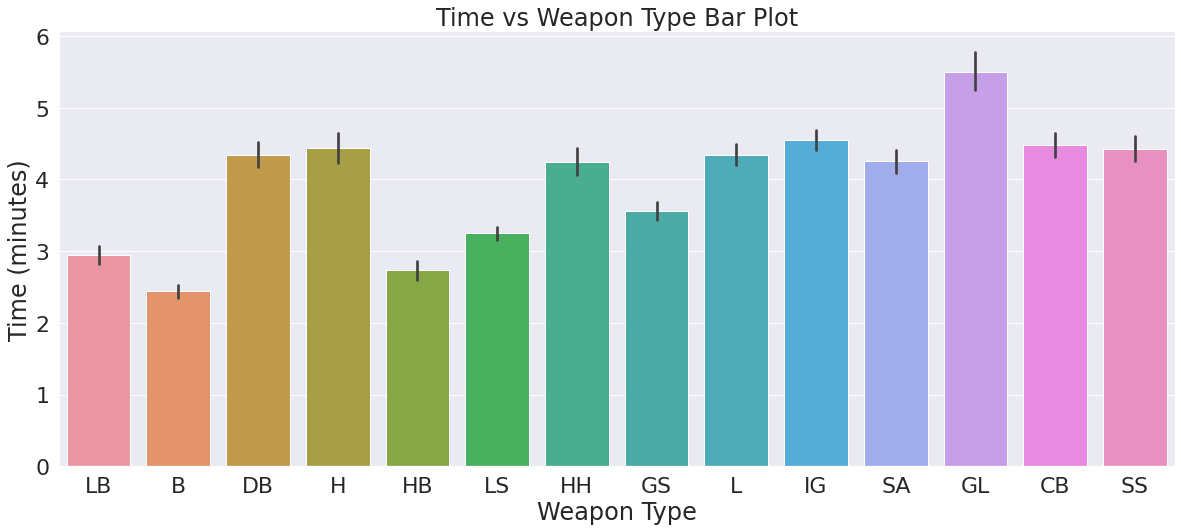

In [43]:
# plotting via barplot
fig4, ax4 = plt.subplots(figsize=(20,8))
ax4 = sns.barplot(x='Weapon',y='Time', data=plotdata_w_vs_t)
ax4.set_title('Time vs Weapon Type Bar Plot')
ax4.set_ylabel('Time (minutes)')
ax4.set_xlabel('Weapon Type')

The Bow, denoted B, has the lowest average quest completion time of about 2.4 minutes, while the Gunlance, denoted GL, has an average completion time of about 5.5 minutes, which considerably higher than the rest, with about a minute difference between the next slowest weapon. Bow doesn't completely dominate though, as the Heavy Bowgun (HB) has an average completion time of about 2.7 minutes compared to Bow's ~2.4. All other weapons also vary significantly within the 2-5.5 minute range, meaning not all weapons are made equal. Thus, the **null hypothesis can be rejected** as weapon type clearly affects quest completion time.

In further analysis of this plot, I noticed that the 3 weapons with the lowest average completion time - **Bow, Heavy Bowgun, and Light Bowgun** - are all primarily **ranged** weapons, while all other weapons are primarily melee (close ranged). This may mean that a weapon's ranged capabilities make it better/deal more DPS (damage per second) and thus correspond to faster quest completion times. Let's keep this in mind going forward, as platform may play a role in this. Keep reading to find out how!

### <center>Platform</center>
<center><img src="kbm.png" width="400" height="200"><img src="switch.png" width="400" height="200"></center>
<center>Keyboard and mouse (left) representing team PC, Nintendo Switch (Right)

MHR is available to play on two platforms: PC and Nintendo Switch. There are pros and cons to both systems in isolation, like PC having higher performance capabilities but low portability, and Switch having the inverse. The aspect I want to look into for this tutorial, though, is in-game, mechanical capabilities. That is, the degree to which the player has control over their character's actions. In MHR, a higher degree of control means better fighting ability and efficiency, which in turn corresponds to lower/faster quest completion times. At least, this is what I suspect. **How does platform affect quest completion time?** Let's check the data.

Text(0, 0.5, 'Time (minutes)')

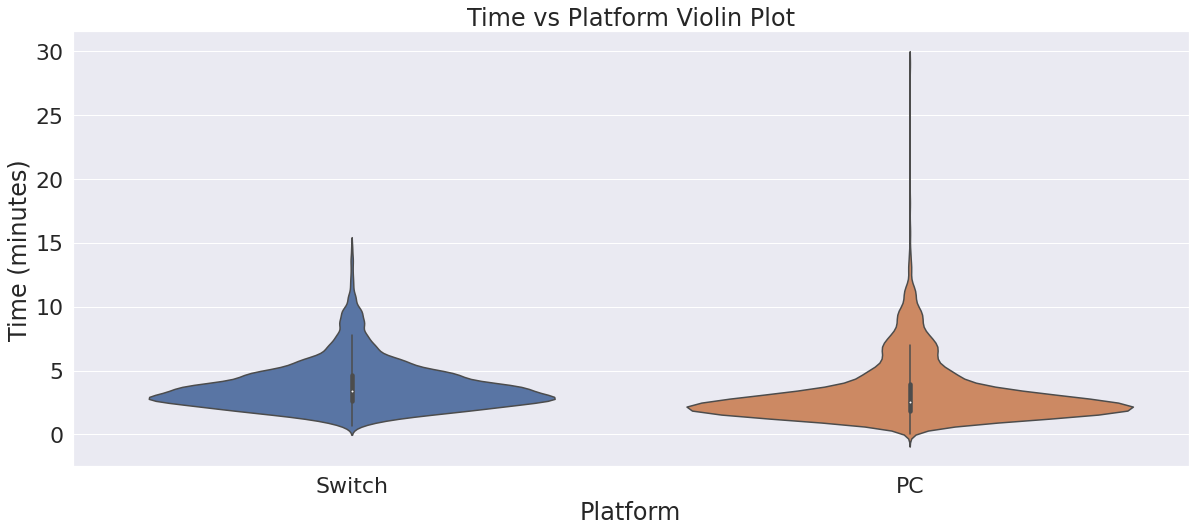

In [44]:
# plotting time vs platform violin
plotdata = total_hunt_df
sns.set(font_scale = 2)
fig5, ax5 = plt.subplots(figsize=(20,8))
ax5 = sns.violinplot(x='Platform',y='Time', data=plotdata)
ax5.set_title('Time vs Platform Violin Plot')
ax5.set_ylabel('Time (minutes)')

Already it looks like PC players perform better than Switch players, but let's first analyze their distributions. The PC distribution shows a more concentrated average than the Switch's, and also has a notable outlier point (probably that Longsword user). Both distributions seem to have a less dramatic negative curve when approaching the higher completion times vs the completion times on the lower end of their respective spectrums, where they tend to converge more quickly, meaning it is far less likely to have an exceptionally low completion time vs a slightly higher time, which is to be expected. PC's high concentration of entries about the average is lower than the Switch's, so we know that PC's lower average time isn't due to outliers - they are **consistently lower** than the majority of Switch completion times. Let's look at this discrepancy closer in a bar plot and do a little more analysis.

Text(0, 0.5, 'Time (minutes)')

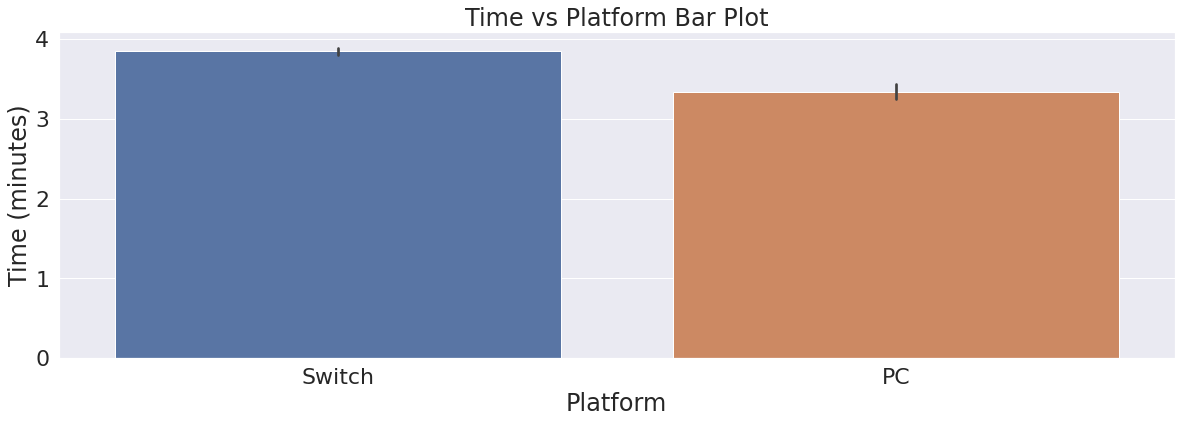

In [45]:
# plotting time vs platform barplot
plotdata = total_hunt_df
fig6, ax6 = plt.subplots(figsize=(20,6))
ax6 = sns.barplot(x='Platform',y='Time', data=plotdata)
ax6.set_title('Time vs Platform Bar Plot')
ax6.set_ylabel('Time (minutes)')

Here we can clearly see that **PC outperforms Switch** in quest completion time, with an average of about 3.3 minutes vs Switch's 3.6. The discrepancy between these averages isn't so large that it warrants concluding that PC runs will gurantee a faster time, but the difference defintely isn't negligible. Already we can **reject the null hypothesis** of quest completion time not being affected by platform. But let's take this a step further:

I believe this discrepancy is due to the mechanical capabilities of playing on a mouse and keyboard. I won't get too into the details, but a PC's mouse and keyboard gives a player a mechanical advantage over console players due to the precision and efficiency granted by the control scheme. Specifically, the **ability to aim** with a mouse is much better than the ability to aim with a joystick. This is why truly competitive FPS (First Person Shooter) games are done virtually exclusively on PC (like <a href="https://en.wikipedia.org/wiki/Counter-Strike%3A_Global_Offensive" target = "CSGO">CSGO</a>) and the most skilled FPS streamers and Youtubers play on PC (like <a href="https://en.wikipedia.org/wiki/Shroud_(gamer)" target = "Shroud">Shroud</a>). My point in saying this is that the prior observations of the Time vs Weapon Type Plots showed that the most effective weapons were **ranged** weapons: Bow, Light Bowgun, and Heavy Bowgun, all of which lend themselves to **FPS-like mechanics** given that they are ranged in nature. The conclusions from both plots match up - PC players have faster quest completion times due to the fact that they are able to **better utilize ranged weapons** through the mechanical advantages granted to them by use of mouse and keyboard.

### <center>Rule</center>
<center><img src="palamute.jpg" width="800" height="400"></center>
<center>Player riding on their <a href="https://monsterhunterrise.wiki.fextralife.com/palamutes" target="Palamute">Palamute</a> as is allowed in FR rules</center>

The last variable I wanted to check was **rule**. There are two rule types for submitting a quest: FR for FreeStyle, where the quest is conducted with no rules except for cheating, and TA for Time Attempt, the rules of which you can read <a href="https://www.mhrspeedrun.com/en/sbwiki/about/submit/" target="here">here</a>. For this, I am not quite sure what to expect as both modes of conducting a quest have their pros and cons for completion time. For FreeStyle, the lack of limitations means players are granted use of **special tools** like Palamutes to get you places faster, use of flash bombs to blind the monster, and a whole bunch of other one-ups. In my mind though, a con would be that the user may not be committing themselves to a Time Attempt run, meaning they might not take their efficiency as seriously since FR runs are more 'care free' in nature. Time Attempts are entirely focused on completing the quest as fast as possible BUT with a limited set of actions. The player can only use their weapon, and **no external tools** or special skills acquired through playing the game. Players conducting Time Attempts are most likely taking their **efficiency more seriously** as they are already abiding by a set of rules, but at the same time don't have the same potential firepower as FreeStyle runs. I don't have a strong guess on which will outperform the other, so my hypothesis matches the null one - that rule type doesn't have any affect on quest completion time / rule type doesn't correspond to quest completion time.

Text(0, 0.5, 'Time (minutes)')

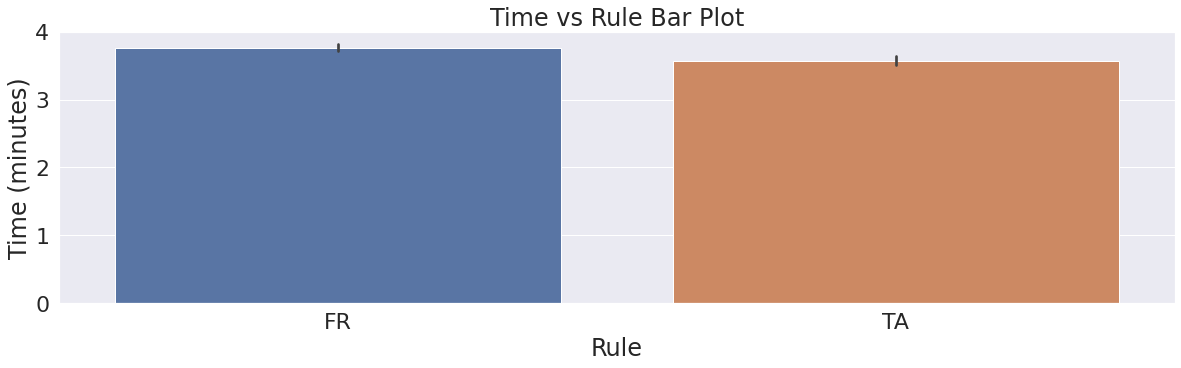

In [46]:
# plotting time vs rule barplot
plotdata = total_hunt_df
fig7, ax7 = plt.subplots(figsize=(20,5))
ax7 = sns.barplot(x='Rule',y='Time', data=plotdata)
ax7.set_title('Time vs Rule Bar Plot')
ax7.set_ylabel('Time (minutes)')

FreeStyle and Time Attempt runs have almost the same average, with FreeStyle at around 3.8 minutes and Time Attempt at about 3.6. Unfortunately, it isn't possible to tell if the restrictions and spirit of the attempt balance eachother out like in my prediction of the pros and cons, resulting in a tie, but we can see that the insignificant difference **supports the null hypothesis** that rule type has no affect on quest completion time.

***
### <center>Data Analysis Conclusion</center>
We have seen that MHR **quest difficulty, weapon type, and platform all have an effect on quest completion time**, as all of their respective null hypotheses have been rejected through data analysis. 

**Higher quest difficulty corresponds to higher quest completion times**, as evident in their exponential positive relationship. While it makes sense that monsters with more HP present in higher difficulty quests take longer to kill, the reason for the exponential nature of the relationship isn't so clear. I believe that it could be in part due to an ofshoot variable of higher monster HP; on any given map, there are monsters present other than the target monster(s), along with various environmental hazards, and other entities that might interfere with the quest. The longer it takes to kill a monster, the higher the chance one of these outside forces interferes with the fight, handicapping the player's ability to fully focus on the target monster(s). The exponentiality comes in with the fact that non-quest-objective monsters present on the current map are of the same or near same difficulty as the monster you are hunting. So as monster health increases with quest difficulty, the HP of other monsters increases along with it. Compound that with more severe environmental hazards present in maps for more difficult monsters, you can start see where this exponential relationship can manifest. 

As for weapon type vs completion time and platform vs completion time, I recorded most of my thoughts on their relationships at the end of the Platform section. To briefly recap, I found that **ranged weapons tended to correlate with faster completion times**. I then found that **PC users also have faster quest completion times compared to Switch users**. From this, I concluded that because of a PC's mouse and keyboard aiming capabilities, PC players could better utilize ranged weapons, as they must be aimed well to be fully taken advantage of. These ranged weapons, as we have seen, output more DPS on average leading to faster quest completion times. 

I then looked into how rule type could affect quest completion time, but found that there was **no significant correlation**. Again, my thoughts about this are recorded in the Rule section, but in short: it may be the case that FreeStyle suffers from inherent relative lack of motiviation to be extremely efficieny but benefits from extra tools in a player's arsenal, while Time Attempt grants the inherent efficiency motivation boost FreeStyle is lacking, but not having those extra tools. I surmized that these pros and cons probably balance eachother out in the end, leading to their similar average completion times.

***
## <center>Further Evaluation</center>

Though I have already explored and analyzed the data relevant to the main topic of this tutorial, I decided to do some further data analysis. I am curious about an additional relationship: **popularity of weapon vs weapon type**. We saw that Bow, Light Bowgun, and Heavy Bowgun, are the most effective weapons, having the three lowest average quest completion times, and Gunlance having the highest quest completion time, with all other weapons varying in between. It is reasonable to assume that players are more attracted to stronger weapons - that is, weapons that correspond to lower quest completion times, as they have been empircally proven to be more efficient through our analysis. Via this line of thought, it should be the case then that weapon popularity (number of entries in the dataset) is proportional to it's efficiency; popular weapon = low average quest completion time (fast), unpopular weapon = high average quest completion time (slow). Let's set the null hypothesis to: weapon efficiency has no effect on popularity.

Text(0, 0.5, 'Number of Entries')

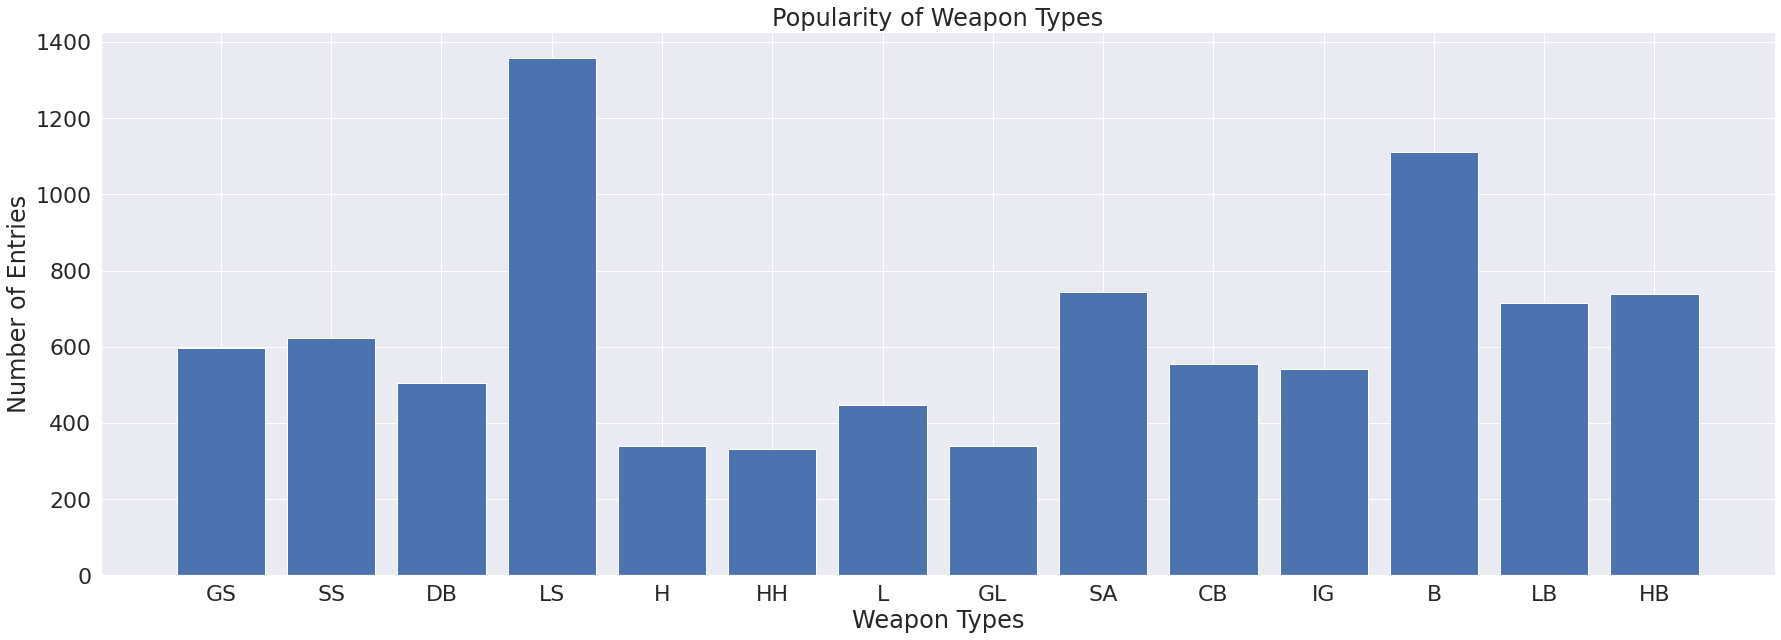

In [47]:
# grouping popularity and average times
weapon_tally = [0 for i in range(len(weapon_initials))]
weapon_time = [0 for i in range(len(weapon_initials))]

for j, weapon in enumerate(total_hunt_df['Weapon']):
    for i, v in enumerate(weapon_initials):
        if v == weapon:
            weapon_tally[i] += 1
            weapon_time[i] += total_hunt_df['Time'][j]
            
for i in range(len(weapon_time)):
    weapon_time[i] /= weapon_tally[i]

# plotting on barplot    
fig8 = plt.figure(figsize=(30,10))
plt.bar(weapon_initials, weapon_tally)
plt.title('Popularity of Weapon Types')
plt.xlabel('Weapon Types')
plt.ylabel('Number of Entries')

Even though the Bow, Light Bowgun, and Heavy Bowgun are the most effective / get the lowest average quest completion times, Longsword (LS) is far more popular than any other weapon type, with more that 1250 entries even though it is only the fourth most effective weapon. The 3 most effective weapons do have a relatively high popularity, though. It is difficult keep in mind which weapons have what effectiveness when trying to break down this relationship, so let's transform this into a scatterplot of weapon popularity vs quest completion time for a better look.

Text(0, 0.5, 'Number of Entries')

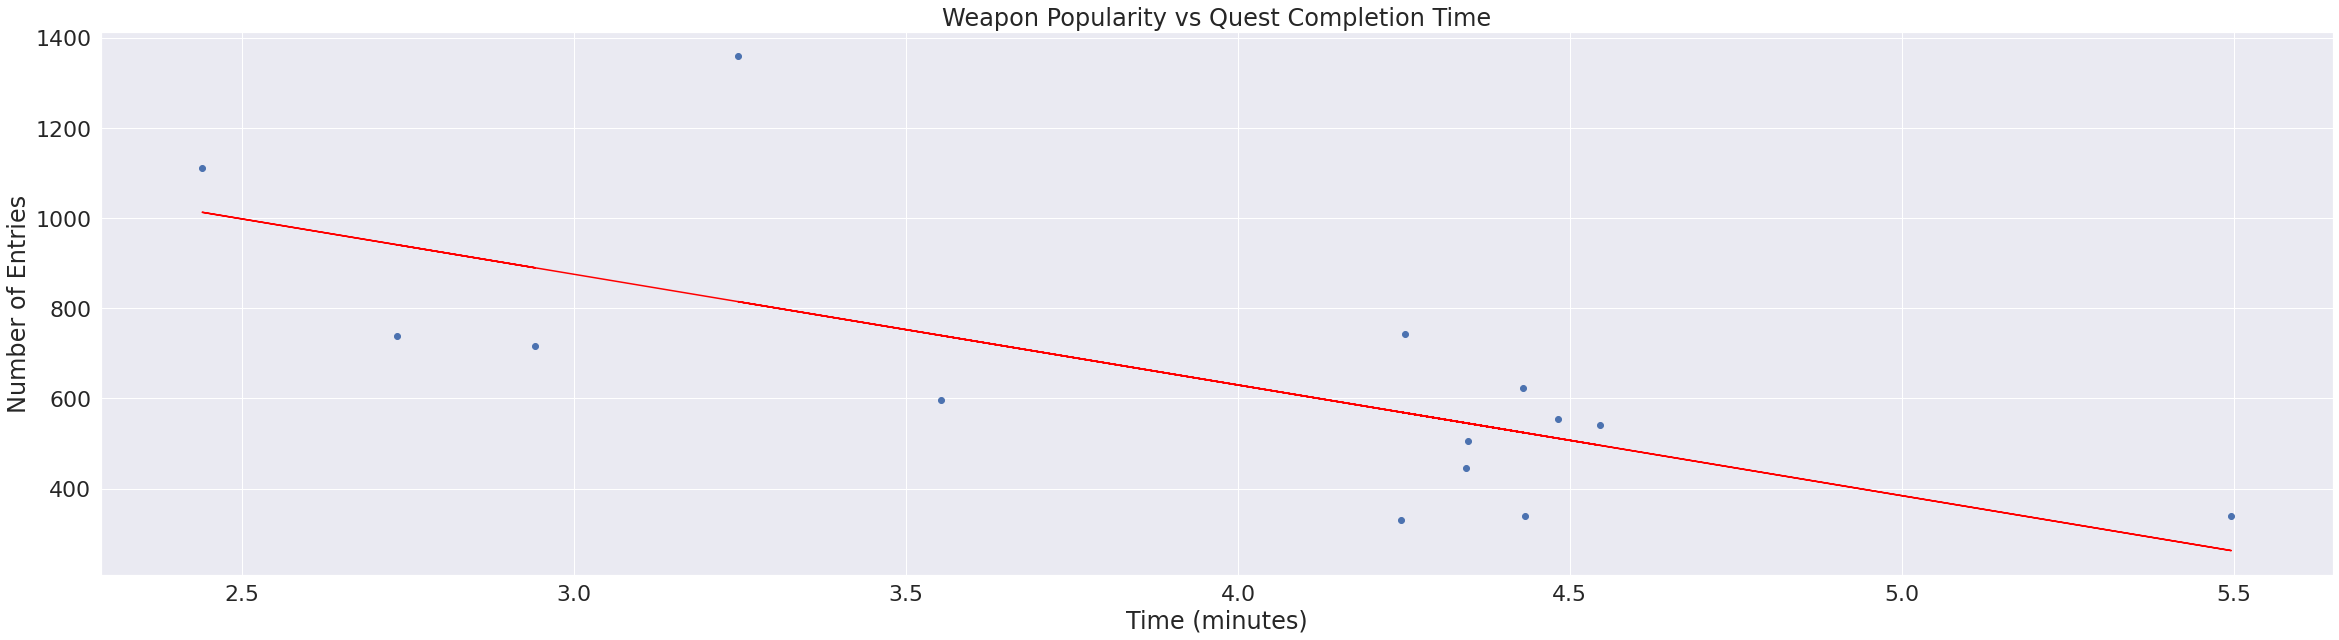

In [48]:
# plotting popularity vs quest completion time
# as a scatterplot with a line of regression
fig9 = plt.figure(figsize=(40,10))
plt.scatter(weapon_time, weapon_tally)
np_time = np.array(weapon_time)
m, b = np.polyfit(np_time, weapon_tally,1)
plt.plot(np_time, m*np_time+b, color='red')
plt.title('Weapon Popularity vs Quest Completion Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Entries')

As we can see from this scatter plot, **fast quest completion time/weapon effectiveness does indeed correspond to high popularity/number of entries**. The line of regression in red shows this trend very clearly, as it has a promininent negative slope as time increases, showing that less popular weapons correspond to higher completion times. The one outlier point is the Longsword, which we identified in the Popularity of Weapon types bar plot. This specific outlier case, I believe, is due to the fact that while not most effective, Longsword is one of the most fun weapons to use; a fact that I can confirm through my time playing MHR and consuming MHR media. Longsword is also known to get many updates to it's moveset, making it's playstyle diverse and engaging for the player. Plus, it's visual appeal makes it a fan favorite. Either way, we can conclude that weapon effectiveness does in fact affect user popularity. This **rejects the null hypothesis of quest completion time not being affected by weapon popularity**.

If you play or consider playing MHR, maybe this tutorial will provide helpful insight into how you decide to approach the game - if you want to be able take down a monster as quickly as possible, first get a PC to game with, try ranged weapons, and pray for good luck in those 8 star quests (haha). In any case, though, having fun when playing games comes above all else; don't let slow quest completion times keep you down. 

Thank you for reading. - Sean Mohs